In [1]:
import math
import numpy as np
import pandas as pd
import sys
import itertools
from functions import *
from mining_functions import *
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
from tabulate import tabulate
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
gitpath = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
df = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

In [3]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

In [17]:
merge_actions = {'C':'C', 'P':'P', 'Tb':'T', 'Tc':'T', 'Ts':'T', 'To':'T'}

def occurrences(string, sub):
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count+=1
        else:
            return count
        
def make_hist_discrete(seq_of_interest,freq_HL,freq_LL):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    ymax= max(max(freq_HL),max(freq_LL))
    bins = range(0,int(ymax)+1,1)
    plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
    plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
    return plt

def make_hist_continuous(seq_of_interest,freq_HL,freq_LL):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    bins = np.arange(0,1.05,0.05)
    plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
    plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
    return plt

def get_frequencies(seq_of_interest,blocks1,blocks2,normalize_by='length'):
    def coo(seq, seq_of_interest):
        return float(occurrences(''.join(seq),seq_of_interest))
    
    if normalize_by == None:
        # count number of occurrences of "seq_of_interest" in a student's seq
        freq1 = {student : coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()}
    elif normalize_by == 'length':
        len_seqi = len(''.join([c for c in seq_of_interest if c.isupper()]))
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the length of seq
        freq1 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks2.iteritems()}
    else:
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the number of occurrences of the seq "normalize_by"
        freq1 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks2.iteritems()}
    return freq1.values(),freq2.values()

def run_chi2(seq_of_interest,blocks1,blocks2,consider_if=None):
    def coo(seq, seq_of_interest):
        if occurrences("".join(seq),seq_of_interest) >=1:
            return 1
        else:
            return 0
        
    if consider_if:
        hl = sum([coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()])
        nhl = sum([coo(seq, consider_if) for student,seq in blocks1.iteritems()])-hl
        ll =  sum([coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()])
        nll = sum([coo(seq, consider_if) for student,seq in blocks2.iteritems()])-ll
    else:
        hl = sum([coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()])
        nhl = len(blocks1.keys())-hl
        ll =  sum([coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()])
        nll = len(blocks2.keys())-ll
    
    to_print = [["","Low-High","Low-Low","total"]]
    to_print.append(["used it",hl,ll,ll+hl])
    to_print.append(["didn't use it",nhl,nll,nll+nhl])
    to_print.append(["total",nhl+hl,nll+ll,nll+ll+nhl+hl])
    print tabulate(to_print)
    
    total = float(hl + nhl + ll + nll)
    print stats.chisquare(f_obs= [hl,ll],   # Array of observed counts
                    f_exp= [(hl+nhl)*(hl+ll)/total,(ll+nll)*(hl+ll)/total])   # Array of expected counts
    return None
# ### Demonstration of function above
# b1 = {1:["A","Bo","C","Bo","C","A","C","A"]}
# b2 = {3:["A","Bo","C","Bo","A","Bo","A","Bo"]}
# f1,f2 = get_frequencies('BoC',b1,b2,normalize_by='Bo')
# print f1,f2

def perform_comparative_stats(seq_of_interest,freq1,freq2):
    t,p =  stats.ttest_ind(freq1,freq2,equal_var=False)
    print seq_of_interest,':'
    print "\tT-test:\t{0} \t p={1}".format(round(t,3),round(p,4))
    m,p = stats.mannwhitneyu(freq1,freq2, alternative='less')
    print '\tHL<LL:\t{0} \t p={1}'.format(round(m,3),round(p,4))
    m,p = stats.mannwhitneyu(freq1,freq2, alternative='greater')
    print '\tHL>LL:\t{0} \t p={1}'.format(round(m,3),round(p,4))
    m,p = stats.mannwhitneyu(freq1,freq2, alternative='two-sided')
    print '\ttwo-sided:\t{0} \t p={1}'.format(round(m,3),round(p,4))
    
# def remodel_families_lightbulb(row):
#     if row["Family"] == "Test_complex":
#         if row['current_#lightBulb']>0:
#             if row["current_#battery"] == 1: 
#                 #we have a simple circuit ;)
#                 if row["current_#loops"] == 1:
#                     if row["current_#resistor"] == 0: #basic circuit!
#                         return 'Test_series_l'
#                     if row["current_#resistor"] == 1: #basic circuit!
#                         return 'Test_series_l_r'
#                     if row["current_#resistor"] == 2: #basic circuit!
#                         return 'Test_series_l_r_r'
#                 elif row["current_#loops"] == 2:
#                     if row["current_#resistor"] == 0: #basic circuit!
#                         return 'Test_parallel_l'
#                     if row["current_#resistor"] == 1: #basic circuit!
#                         return 'Test_parallel_l_r'
#                     if row["current_#resistor"] == 2: #basic circuit!
#                         return 'Test_parallel_l_r_r'
#     return row["Family"]
# df2 = df.copy()
# df2['Family'] = df2.apply (lambda row: remodel_families_lightbulb (row),axis=1)

# blocks_HL_lightbulb, time_coords_HL =  get_blocks_withTime_new(df2,students_HL,"Family",start=False,ignore=['I'], as_list=True)
# blocks_LL_lightbulb, time_coords_LL =  get_blocks_withTime_new(df2,students_LL,"Family",start=False,ignore=['I'], as_list=True)

# Story line
This notebook raises and explores hypotheses generated fom the analysis in the notebook  "temporal_sequence_infogain_mining.ipynb"

Here are the Hypotheses:
* CTsPTsP (HL)
    * TsP
        * Ts (**1.1**)
        * TP (**1.2**)
    * TsPTsP
        * TPTP (**2.1**)
* PCTcCTcC (LL)
    * TcC
        * Tc (**3.1**)
        * TC (**3.2**)
    * TcCTcC
        * TCTC (**4.1**)
* PCPCTcC (LL)
    * PC (**5.1**)
    * CP (**5.2**)
* PTsPC (HL)
    * PTs
    * PT (**6**)


# Frequency analysis of single blocks of actions -> Hypotheses 1.1 and 3.1
First we get the sequence of action of each students in blocks. Recall that we only look at students who had a low pre.
We also ignore the Interface actions becasue they aren't interesting.

In [5]:
students_Lpre = set(get_students('split pre','low'));H_post = set(get_students('split post t2','high'));L_post = set(get_students('split post t2','low'))
students_HL = H_post.intersection(students_Lpre)
students_LL = L_post.intersection(students_Lpre)
print "There are {0} low pre students, of which {1} are high learners and {2} low learners.".format(len(students_Lpre),len(students_HL),len(students_LL))

There are 74 low pre students, of which 38 are high learners and 36 low learners.


In [6]:
blocks_HL, time_coords_HL =  get_blocks_withTime_new(df,students_HL,"Family",start=False,ignore=['I'], as_list=True)
blocks_LL, time_coords_LL =  get_blocks_withTime_new(df,students_LL,"Family",start=False,ignore=['I'], as_list=True)
blocks_Lpre, time_coords_Lpre =  get_blocks_withTime_new(df,students_Lpre,"Family",start=False,ignore=['I'], as_list=True)
blocks_merged_HL = {student:[merge_actions[s] for s in seq] for student,seq in blocks_HL.iteritems()}
blocks_merged_LL = {student:[merge_actions[s] for s in seq] for student,seq in blocks_LL.iteritems()}
blocks_merged_Lpre = {student:[merge_actions[s] for s in seq] for student,seq in blocks_Lpre.iteritems()}
actions_merged = ['C','P','T']
actions_all = ['C', 'P', 'Tb', 'Tc', 'Ts']

We may need to plot sequences so let's load them up

In [7]:
CUT_OFF = 0.35 #we keep only sequences used once by at least 20% of students
shortest_seq_length = 1
longest_seq_length = 10
B = 4  #number of bins
family_category = "Family"
sequence_counts = get_sequence_use_by_timebin(df,students_Lpre,family_category,
                                                          B,'split post t2','high','low',
                                                          shortest_seq_length,longest_seq_length,CUT_OFF)

Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


First we need to check that students tend to do the same number of blocks of actions in their sequences

length in time :
	T-test:	-1.729 	 p=0.0882
	HL<LL:	520.0 	 p=0.0385
	HL>LL:	520.0 	 p=0.9624


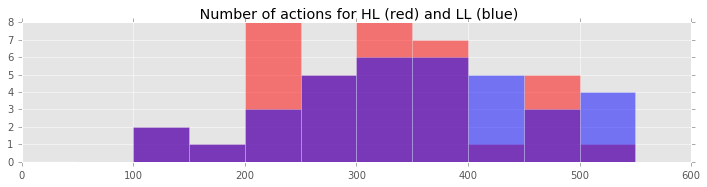

In [13]:
number_of_actions_HL = [len(list(df[df['student']==student]['Family'])) for student in students_HL]
number_of_actions_LL = [len(list(df[df['student']==student]['Family'])) for student in students_LL]
fig, axs = plt.subplots(1,figsize=(12,2.5))
ymax= int(max(max(number_of_actions_HL),max(number_of_actions_LL)))
bins = range(0,ymax+5,50)
plt.hist(number_of_actions_HL,color ='r',alpha = 0.5,bins = bins);plt.hist(number_of_actions_LL,color = 'b',alpha = 0.5,bins = bins)
plt.title(" Number of actions for HL (red) and LL (blue)")
perform_comparative_stats('length in time',number_of_actions_HL,number_of_actions_LL)

number of actions in time :
	T-test:	-1.729 	 p=0.0882
	HL<LL:	520.0 	 p=0.0385
	HL>LL:	520.0 	 p=0.9624
336.5 108.469979656


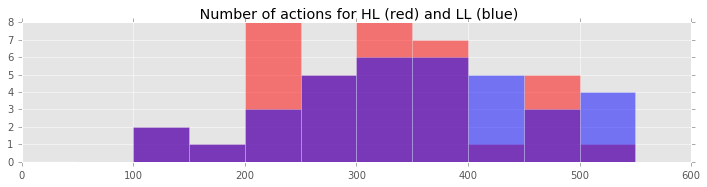

In [14]:
number_of_actions_HL = [len(list(df[df['student']==student]['Family'])) for student in students_HL]
number_of_actions_LL = [len(list(df[df['student']==student]['Family'])) for student in students_LL]
fig, axs = plt.subplots(1,figsize=(12,2.5))
ymax= int(max(max(number_of_actions_HL),max(number_of_actions_LL)))
bins = range(0,ymax+5,50)
plt.hist(number_of_actions_HL,color ='r',alpha = 0.5,bins = bins);plt.hist(number_of_actions_LL,color = 'b',alpha = 0.5,bins = bins)
plt.title(" Number of actions for HL (red) and LL (blue)")
perform_comparative_stats('number of actions in time',number_of_actions_HL,number_of_actions_LL)
L = number_of_actions_HL
L.extend(number_of_actions_LL)
print np.mean(L), np.std(L)

length in blocks :
	T-test:	-1.774 	 p=0.0804
	HL<LL:	530.5 	 p=0.0489
	HL>LL:	530.5 	 p=0.9522
47.4189189189 16.4784927453


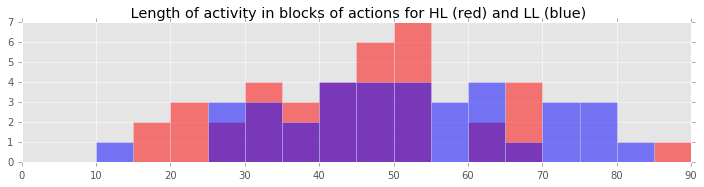

In [16]:
length_HL = [len(seq) for seq in blocks_HL.values()];length_LL = [len(seq) for seq in blocks_LL.values()]
fig, axs = plt.subplots(1,figsize=(12,2.5))
ymax= max(max(length_HL),max(length_LL))
bins = range(0,ymax+5,5)
plt.hist(length_HL,color ='r',alpha = 0.5,bins = bins);plt.hist(length_LL,color = 'b',alpha = 0.5,bins = bins)
plt.title(" Length of activity in blocks of actions for HL (red) and LL (blue)")
perform_comparative_stats('length in blocks',length_HL,length_LL)
L = length_HL
L.extend(length_LL)
print np.mean(L), np.std(L)

Indeed they do not! We are going to have to normalize given the length of each student's sequence.

But first let's see how many blocks of each type of action students do.

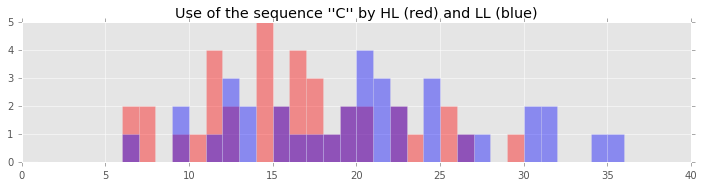

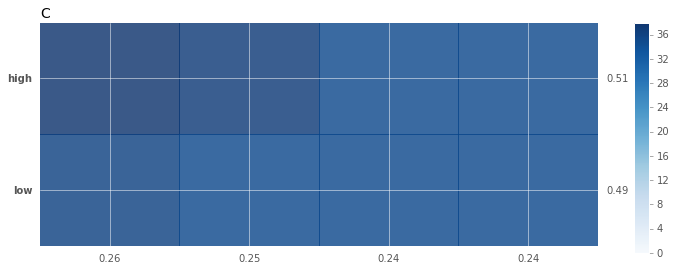

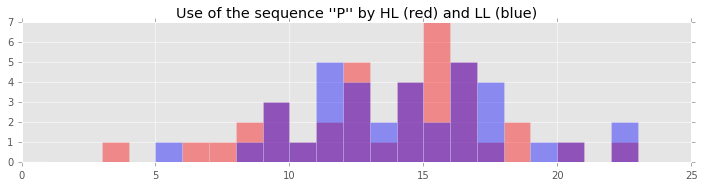

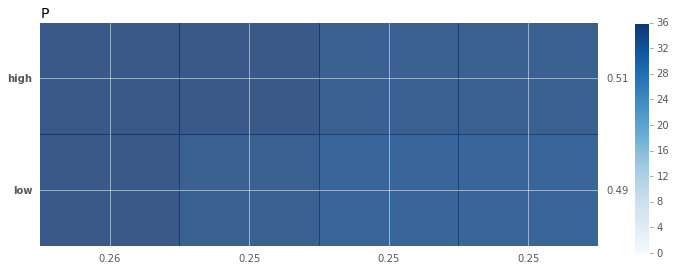

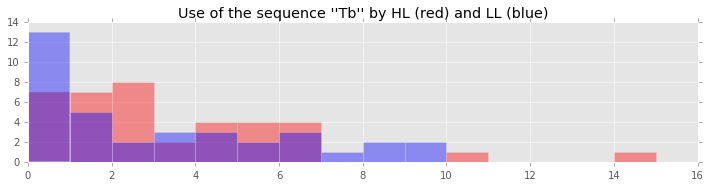

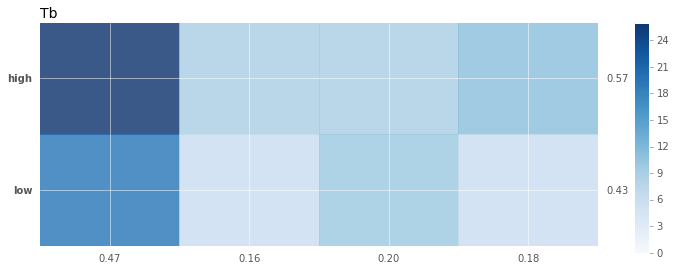

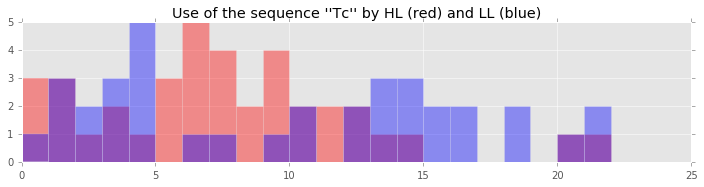

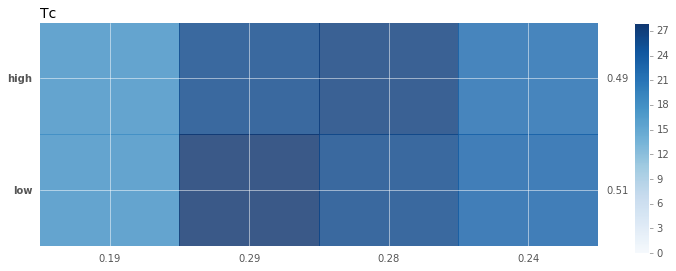

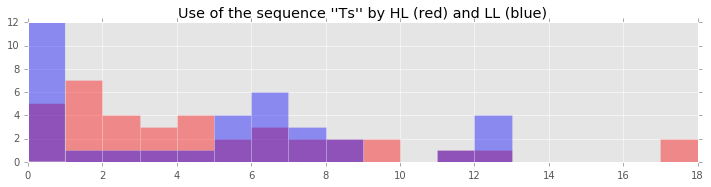

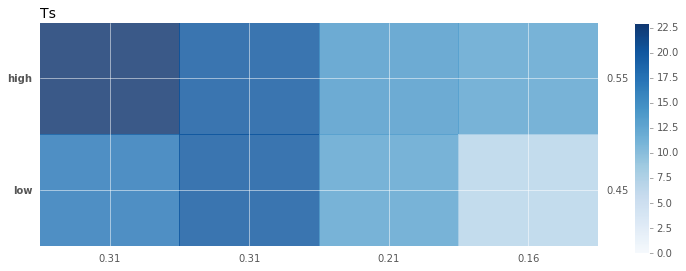

In [10]:
for action in actions_all:
    freq_HL,freq_LL = get_frequencies(action,blocks_HL,blocks_LL,normalize_by=None)
    make_hist_discrete(action,freq_HL,freq_LL)
    plot_heat_map(sequence_counts[action],action,('high','low'))

We notice that:
* Everyone constructs and pause during the entire activity
* Everyone Test simple and basic early as well as Test complex late. 
* some students never Test basic (13 LL, 6 HL) nor Test simple (13 LL and 5 HL).
* Several LL do many many Test complex actions, and do them earlier on in the activity
* Several LL have more Construct blocks.

Note that we don't look at Test other because only 9 students use it.

We can do some t-tests to confirm that most patterns above are not significant.


## Let's repeat the analysis normalizing by sequence length
Note that a frequency near 100% means that the student does a block of that action between nearly every other block.
Not that we need to chose the right statistical test:
* T-test if the data is normal
* Mann-Whitney if it is not, and depending on if we want to say HL does it more than LL or vice versa the direction of the p-value test

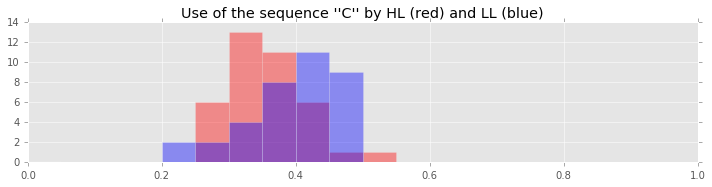

C :
	T-test:	-2.556 	 p=0.0128
	HL<LL:	412.5 	 p=0.0017
	HL>LL:	412.5 	 p=0.9984
	two-sided:	412.5 	 p=0.0034


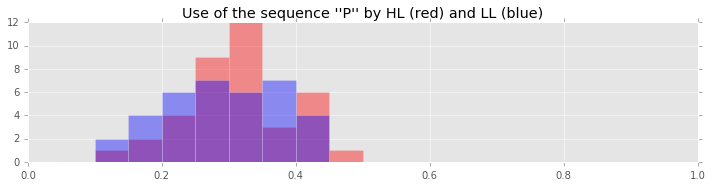

P :
	T-test:	1.111 	 p=0.2704
	HL<LL:	780.0 	 p=0.8517
	HL>LL:	780.0 	 p=0.1508
	two-sided:	780.0 	 p=0.3016


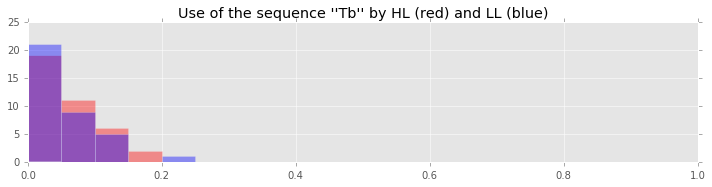

Tb :
	T-test:	0.925 	 p=0.3579
	HL<LL:	803.5 	 p=0.905
	HL>LL:	803.5 	 p=0.0968
	two-sided:	803.5 	 p=0.1936


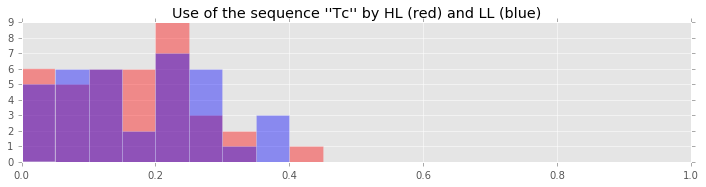

Tc :
	T-test:	-0.72 	 p=0.4737
	HL<LL:	622.5 	 p=0.2547
	HL>LL:	622.5 	 p=0.7488
	two-sided:	622.5 	 p=0.5094


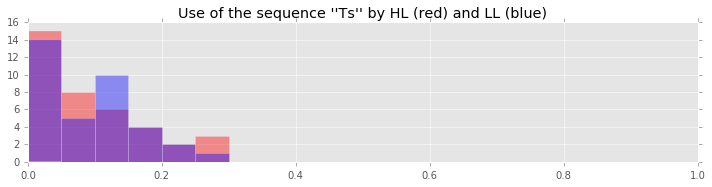

Ts :
	T-test:	0.877 	 p=0.3836
	HL<LL:	759.0 	 p=0.7943
	HL>LL:	759.0 	 p=0.2088
	two-sided:	759.0 	 p=0.4176


In [18]:
for action in actions_all:
    freq_HL,freq_LL = get_frequencies(action,blocks_HL,blocks_LL,normalize_by='length')
    plot = make_hist_continuous(action,freq_HL,freq_LL)
    plot.show()
    perform_comparative_stats(action,freq_HL,freq_LL)

** <font color='blue'> Clearly, LL have more construction blocks per number of action blocks ($p < 0.05$) </font> **

# Let's start digging into our Hypotheses
## Hypothesis 1.2 and 3.2: What to do after testing? 
### HL do more TsP?
Let's see if they Test simple then pause more, given the length of their sequences (normalizing by it)
and then given the number of times they Test simple (normalizing by the number of times they Test simple)

TsP :
	T-test:	1.941 	 p=0.0565
	HL<LL:	848.5 	 p=0.9653
	HL>LL:	848.5 	 p=0.0356
	two-sided:	848.5 	 p=0.0711
0.0557275541796 0.0333333333333


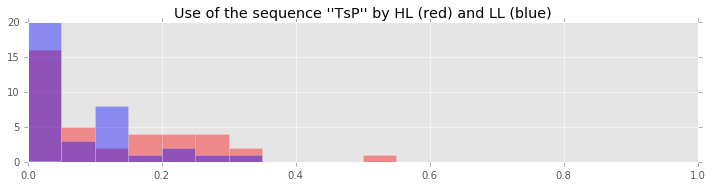

In [19]:
seq = 'TsP'
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='length')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)
print np.median(freq_HL),np.median(freq_LL)

TsP :
	T-test:	2.789 	 p=0.0068
	HL<LL:	919.0 	 p=0.9953
	HL>LL:	919.0 	 p=0.0049
	two-sided:	919.0 	 p=0.0098
0.514705882353 0.2


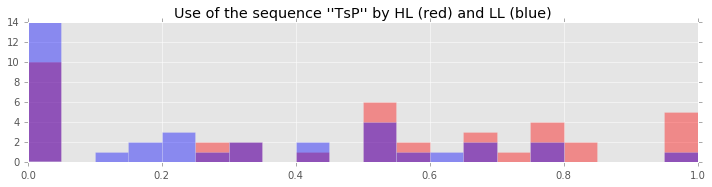

In [20]:
seq = 'TsP'
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='Ts')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)
print np.median(freq_HL),np.median(freq_LL)

** <font color='blue'> Not only do they TsP more overall ($p < 0.05$) </font> **

** <font color='blue'> They also Pause more after Testing simple. ($p < 0.01$) </font> **

Do LL Construct after Testing simple then?

### LL do more TcC?

TcC :
	T-test:	-1.789 	 p=0.0779
	HL<LL:	508.5 	 p=0.029
	HL>LL:	508.5 	 p=0.9717
	two-sided:	508.5 	 p=0.058
0.108387096774 0.166666666667


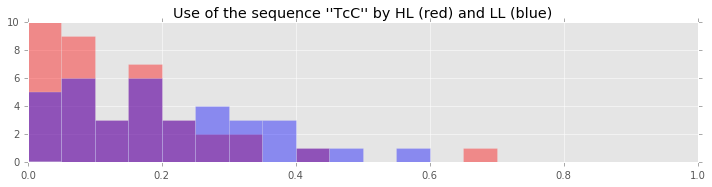

In [21]:
seq = 'TcC'
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='length')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)
print np.median(freq_HL),np.median(freq_LL)

TcC :
	T-test:	-2.511 	 p=0.0143
	HL<LL:	440.5 	 p=0.0042
	HL>LL:	440.5 	 p=0.9959
	two-sided:	440.5 	 p=0.0084
0.392307692308 0.566964285714


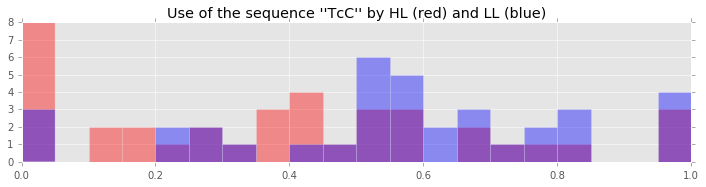

In [22]:
seq = 'TcC'
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='Tc')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)
print np.median(freq_HL),np.median(freq_LL)

TsC :
	T-test:	-0.864 	 p=0.3908
	HL<LL:	639.0 	 p=0.3113
	HL>LL:	639.0 	 p=0.6926
	two-sided:	639.0 	 p=0.6227
0.0465367965368 0.0619047619048


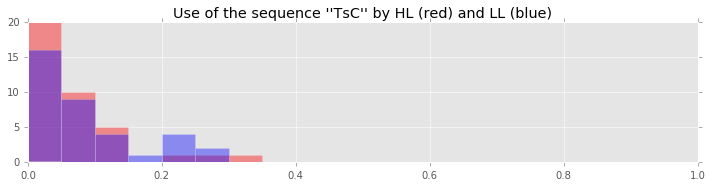

In [23]:
seq = 'TsC'
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='length')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)
print np.median(freq_HL),np.median(freq_LL)

TsC :
	T-test:	-0.535 	 p=0.5946
	HL<LL:	620.5 	 p=0.2427
	HL>LL:	620.5 	 p=0.7607
	two-sided:	620.5 	 p=0.4854
0.25 0.333333333333


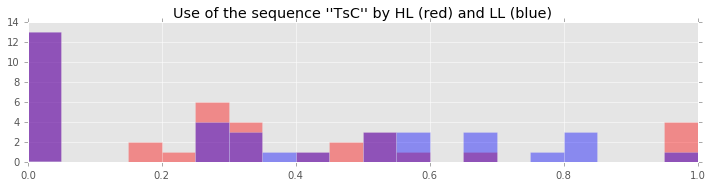

In [24]:
seq = 'TsC'
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='Ts')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)
print np.median(freq_HL),np.median(freq_LL)

** <font color='blue'> LL don't necessarily Test complex + Construct more often but they do Construct after Testing Complex more ($p < 0.05$) </font> **

### Let's generalize these hypotheses and repeat the analysis for TP and TC
We merge all test actions (and don't ignore Test Other for this analysis)

TP :
	T-test:	2.857 	 p=0.0056
	HL<LL:	977.5 	 p=0.9993
	HL>LL:	977.5 	 p=0.0008
	two-sided:	977.5 	 p=0.0015
0.344998559238 0.120870182169 0.256501737213 0.140600117592


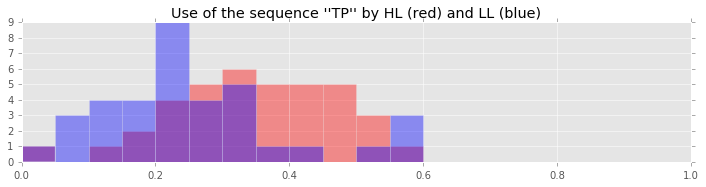

In [25]:
seq = 'TP'
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='length')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)
print np.mean(freq_HL),np.std(freq_HL),np.mean(freq_LL),np.std(freq_LL)

TP :
	T-test:	2.601 	 p=0.0113
	HL<LL:	921.0 	 p=0.9949
	HL>LL:	921.0 	 p=0.0052
	two-sided:	921.0 	 p=0.0105
0.525683373217 0.194524002267 0.405511225712 0.197207992807


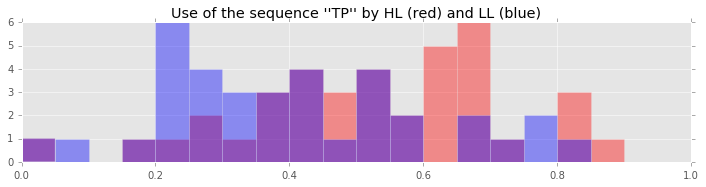

In [26]:
seq = 'TP'
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='T')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)
print np.mean(freq_HL),np.std(freq_HL),np.mean(freq_LL),np.std(freq_LL)

TC :
	T-test:	-1.769 	 p=0.0812
	HL<LL:	524.5 	 p=0.0427
	HL>LL:	524.5 	 p=0.9582
	two-sided:	524.5 	 p=0.0855
0.284175114475 0.152271002469 0.348282219672 0.155036496383


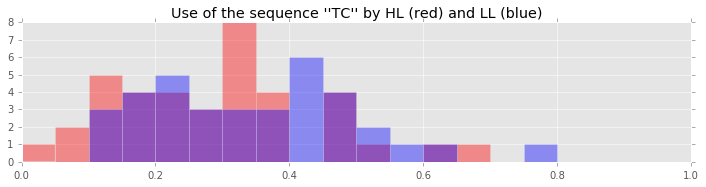

In [27]:
seq = 'TC'
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='length')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)
print np.mean(freq_HL),np.std(freq_HL),np.mean(freq_LL),np.std(freq_LL)

TC :
	T-test:	-2.97 	 p=0.004
	HL<LL:	400.5 	 p=0.0011
	HL>LL:	400.5 	 p=0.9989
	two-sided:	400.5 	 p=0.0022
0.419948448921 0.202000037921 0.557413769732 0.190738914399


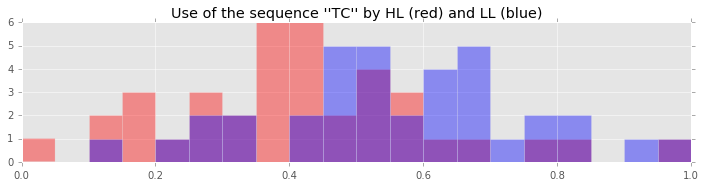

In [28]:
seq = 'TC'
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='T')
make_hist_continuous(seq,freq_HL,freq_LL)
perform_comparative_stats(seq,freq_HL,freq_LL)
print np.mean(freq_HL),np.std(freq_HL),np.mean(freq_LL),np.std(freq_LL)

** <font color='blue'> HL Test and Pause more overall ($p < 0.05$) as well as Pause more after Testing ($p < 0.05$)</font> **

** <font color='blue'> LL don't necessarily Test and Constrcut more overall but they do Construct after Testing more ($p < 0.01$) </font> **

## Hypothesis 5.1 and 5.2: LL do more CP or PC?

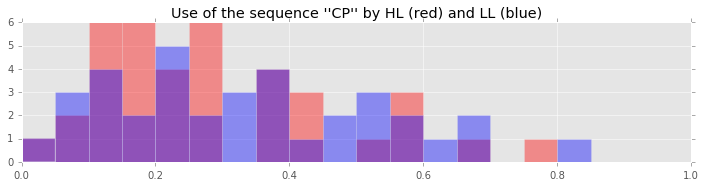

CP :
	T-test:	-1.032 	 p=0.3059
	HL<LL:	598.5 	 p=0.179
	HL>LL:	598.5 	 p=0.8239
	two-sided:	598.5 	 p=0.3579


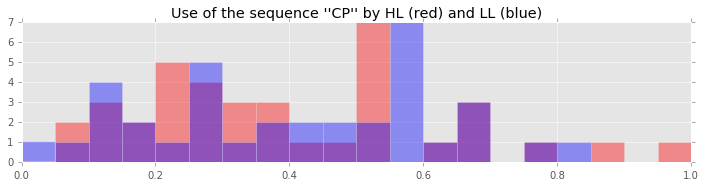

CP :
	T-test:	-0.286 	 p=0.7753
	HL<LL:	641.5 	 p=0.3248
	HL>LL:	641.5 	 p=0.6791
	two-sided:	641.5 	 p=0.6495


In [29]:
seq = 'CP'
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='length')
plot = make_hist_continuous(seq,freq_HL,freq_LL)
plot.show()
perform_comparative_stats(seq,freq_HL,freq_LL)
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='C')
plot = make_hist_continuous(seq,freq_HL,freq_LL)
plot.show()
perform_comparative_stats(seq,freq_HL,freq_LL)

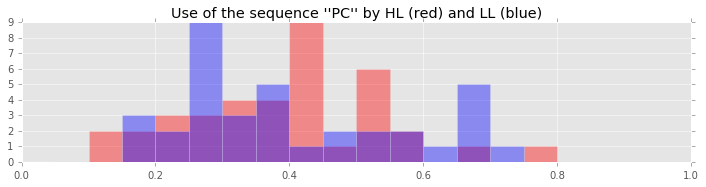

PC :
	T-test:	-0.451 	 p=0.6531
	HL<LL:	684.0 	 p=0.5022
	HL>LL:	684.0 	 p=0.5022
	two-sided:	684.0 	 p=0.9957


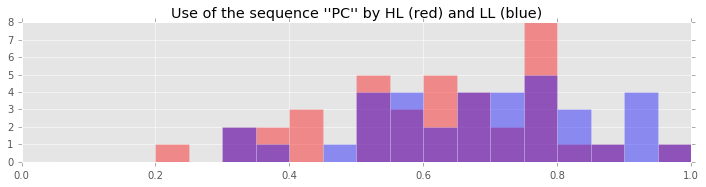

PC :
	T-test:	-1.806 	 p=0.0751
	HL<LL:	522.5 	 p=0.0407
	HL>LL:	522.5 	 p=0.9603
	two-sided:	522.5 	 p=0.0813


In [30]:
seq = 'PC'
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='length')
plot = make_hist_continuous(seq,freq_HL,freq_LL)
plot.show()
perform_comparative_stats(seq,freq_HL,freq_LL)
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='P')
plot = make_hist_continuous(seq,freq_HL,freq_LL)
plot.show()
perform_comparative_stats(seq,freq_HL,freq_LL)

So no trends whatsoever... but clearly pauses are important after testing, so let's investigate.
## So everyone pauses during the activity, but they possibly use pauses differently...

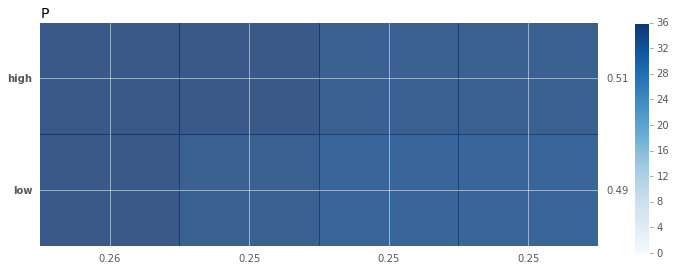

In [31]:
plot = plot_heat_map(sequence_counts['P'],'P',('high','low'))

Let's look at the following sequences:
* TPC may suggest a form of reflection with potentially some planning of a construction (results of test are recorded and/or driving the next construction)
* TPT is most probably reflection between tests or prediction of next test
* CPT is prediction OR reflecting on implicit feedback from construction
* CPC demonstrates planning of a construction or implicit feedback from construction

### First let's compare the groups and sequences normalizing by the number of pausses.

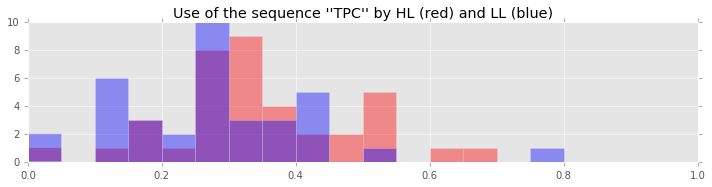

TPC :
	T-test:	1.98 	 p=0.0516
	HL<LL:	883.5 	 p=0.9849
	HL>LL:	883.5 	 p=0.0155
	two-sided:	883.5 	 p=0.031
0.342646704431 0.134779359671
0.276541710677 0.147703180477


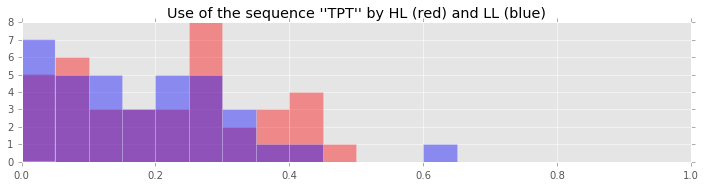

TPT :
	T-test:	1.119 	 p=0.2668
	HL<LL:	807.0 	 p=0.9099
	HL>LL:	807.0 	 p=0.0919
	two-sided:	807.0 	 p=0.1838
0.209612809361 0.138486636072
0.172967455747 0.139242945578


In [32]:
for seq in ['TPC','TPT']:
    freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='P')
    plot = make_hist_continuous(seq,freq_HL,freq_LL)
    plot.show()
    perform_comparative_stats(seq,freq_HL,freq_LL)
#     freq_HL.extend(freq_LL)
    print np.mean(freq_HL), np.std(freq_HL)
    print np.mean(freq_LL), np.std(freq_LL)

HL and LL are not very different here in their use of these sequences, however overall, students TPC more then they TPT
This may suggest that iterative testing on the same circuit or the comparison of circuits is not a frequent strategy. Students only perform a single block of Test + Pause before constructing again

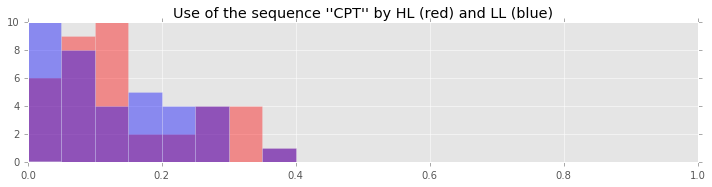

CPT :
	T-test:	1.161 	 p=0.2493
	HL<LL:	776.0 	 p=0.8428
	HL>LL:	776.0 	 p=0.1598
	two-sided:	776.0 	 p=0.3197
0.144105455948 0.107544502073
0.116027754884 0.097546950955


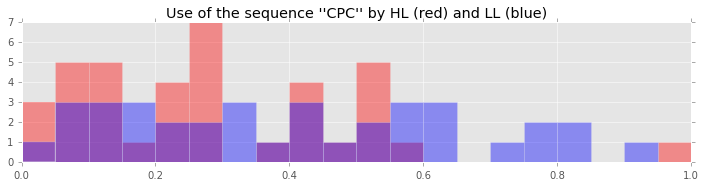

CPC :
	T-test:	-2.508 	 p=0.0145
	HL<LL:	466.0 	 p=0.0093
	HL>LL:	466.0 	 p=0.991
	two-sided:	466.0 	 p=0.0186
0.270842446597 0.20378391483
0.406300209258 0.250558608561


In [33]:
for seq in ['CPT','CPC']:
    freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='P')
    plot = make_hist_continuous(seq,freq_HL,freq_LL)
    plot.show()
    perform_comparative_stats(seq,freq_HL,freq_LL)
#     freq_HL.extend(freq_LL)
    print np.mean(freq_HL), np.std(freq_HL)
    print np.mean(freq_LL), np.std(freq_LL)

** <font color='blue'> LL don't necessarily CPT given how much they pause but they do CPC more ($p < 0.05$) </font> **

In other words, LL spend a lot of time planning their construction of their circuits OR use their construction to get implicit feedback. But again this goes back to Testing as the feedback you get impplicitly is immediate and requires attention at the right time. Moreover not all implicit feedback may be noticed by the student.

### Now let's do a very similar analysis normalizing this time by the first two action of the sequence

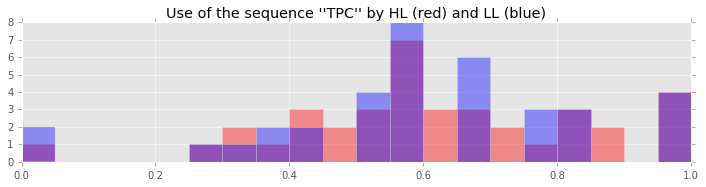

TPC :
	T-test:	0.231 	 p=0.8178
	HL<LL:	691.0 	 p=0.5324
	HL>LL:	691.0 	 p=0.4719
	two-sided:	691.0 	 p=0.9438


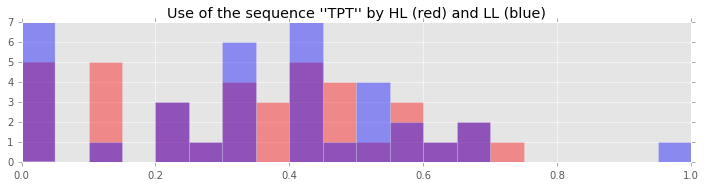

TPT :
	T-test:	-0.234 	 p=0.8157
	HL<LL:	675.0 	 p=0.4632
	HL>LL:	675.0 	 p=0.5411
	two-sided:	675.0 	 p=0.9265


In [34]:
for seq in ['TPC','TPT']:
    freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='TP')
    plot = make_hist_continuous(seq,freq_HL,freq_LL)
    plot.show()
    perform_comparative_stats(seq,freq_HL,freq_LL)

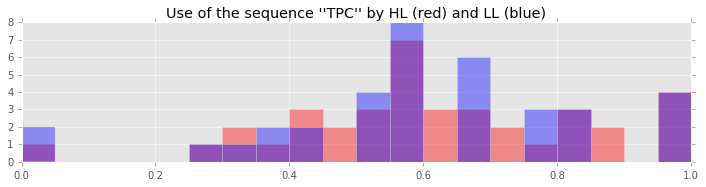

TPC :
	T-test:	0.231 	 p=0.8178
	HL<LL:	691.0 	 p=0.5324
	HL>LL:	691.0 	 p=0.4719
	two-sided:	691.0 	 p=0.9438


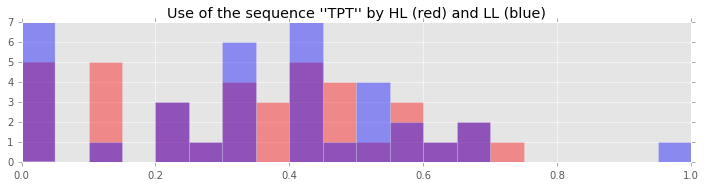

TPT :
	T-test:	-0.234 	 p=0.8157
	HL<LL:	675.0 	 p=0.4632
	HL>LL:	675.0 	 p=0.5411
	two-sided:	675.0 	 p=0.9265


In [35]:
for seq in ['TPC','TPT']:
    freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='TP')
    plot = make_hist_continuous(seq,freq_HL,freq_LL)
    plot.show()
    perform_comparative_stats(seq,freq_HL,freq_LL)

We find a very similar pattern: students TPC more than they iteratively test (TPT)

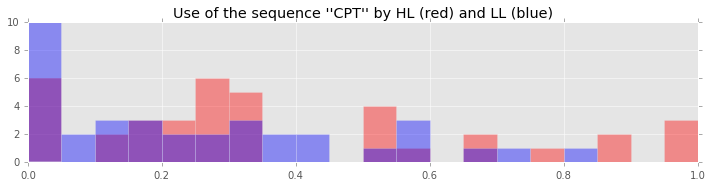

CPT :
	T-test:	1.918 	 p=0.0592
	HL<LL:	838.0 	 p=0.9537
	HL>LL:	838.0 	 p=0.0474
	two-sided:	838.0 	 p=0.0948


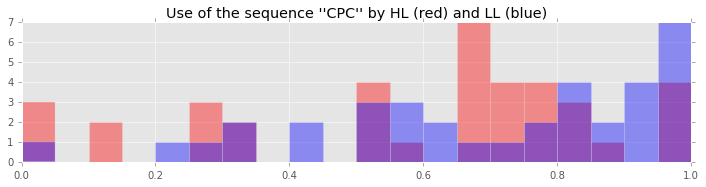

CPC :
	T-test:	-1.734 	 p=0.0872
	HL<LL:	528.5 	 p=0.0463
	HL>LL:	528.5 	 p=0.9547
	two-sided:	528.5 	 p=0.0926


In [36]:
for seq in ['CPT','CPC']:
    freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='CP')
    plot = make_hist_continuous(seq,freq_HL,freq_LL)
    plot.show()
    perform_comparative_stats(seq,freq_HL,freq_LL)

Given a construction and pause block, students tend to construct rather then Test.

However, almost a third of LL  (10 students) never T after a CP block and in general they do it less then HL.

Thus, if Testing after a Construct and Pause block is a sign of prediction, LL use pauses as predctions less than HL.

## Let's look at pauses a different way
We export pause counts for analysis in SPSS

In [37]:
data = np.chararray(shape=(len(students_HL)+len(students_LL)+1,6),itemsize=1000)
data[1:,0] = [str(s) for s in students_Lpre]
data[0,:] = ['Studentid','Group','PT','PC','CP','TP']
for student in students_Lpre:
    row = np.where(data==str(student))[0][0]
    if student in students_HL:
        group='LH'
        seq = blocks_merged_HL[student]
    else:
        group = 'LL'
        seq = blocks_merged_LL[student]
    
    PT = occurrences("".join(seq),'PT')
    PC = occurrences("".join(seq),'PC')
    CP = occurrences("".join(seq),'CP')
    TP = occurrences("".join(seq),'TP')
    data[row,1:] = [group,PT,PC,CP,TP]
    
np.savetxt('pause_counts_TP_for_SPSS_analysis.txt', data, delimiter=',', newline='\n', header='',fmt='%.15s')

In [38]:
data = np.chararray(shape=(len(students_HL)+len(students_LL)+1,7),itemsize=1000)
data[1:,0] = [str(s) for s in students_Lpre]
data[0,:] = ['Studentid','Group','TPT','TPC','CPC','CPT','Num P']
for student in students_Lpre:
    row = np.where(data==str(student))[0][0]
    if student in students_HL:
        group=1
        seq = blocks_merged_HL[student]
    else:
        group = 0
        seq = blocks_merged_LL[student]
    
    TPT = occurrences("".join(seq),'TPT')
    TPC = occurrences("".join(seq),'TPC')
    CPC = occurrences("".join(seq),'CPC')
    CPT = occurrences("".join(seq),'CPT')
    P = occurrences("".join(seq),'P')
    data[row,1:] = [group,TPT,TPC,CPC,CPT, TPT+TPC+CPC+CPT]
    
np.savetxt('pause_counts_TPT_for_SPSS_analysis.txt', data, delimiter=',', newline='\n', header='',fmt='%.1000s')

## What about repetitions of building blocks?
Instead of looking at frequencies, since students may only have used this strategy once, we use a different analysis method to determine if they were used differently by the two student groups

-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        14        7        21
didn't use it  24        29       53
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=1.971734892787524, pvalue=0.16026383324334748)
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        14        7        21
didn't use it  14        15       29
total          28        22       50
-------------  --------  -------  -----
Power_divergenceResult(statistic=0.96969696969696983, pvalue=0.32475576540261852)
TsPTsP :
	T-test:	1.186 	 p=0.2394
	HL<LL:	789.5 	 p=0.9254
	HL>LL:	789.5 	 p=0.0766
	two-sided:	789.5 	 p=0.1532


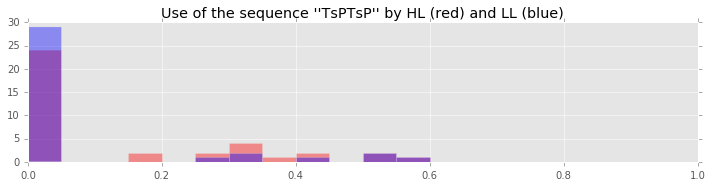

In [39]:
seq = 'TsPTsP'
run_chi2(seq,blocks_HL,blocks_LL)
run_chi2(seq,blocks_HL,blocks_LL,consider_if='TsP')
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='TsP')
perform_comparative_stats(seq,freq_HL,freq_LL)
plot = make_hist_continuous(seq,freq_HL,freq_LL)

-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        29        19       48
didn't use it  9         17       26
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=1.5790082846003894, pvalue=0.2089035999308676)
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        29        19       48
didn't use it  8         16       24
total          37        35       72
-------------  --------  -------  -----
Power_divergenceResult(statistic=1.5660231660231652, pvalue=0.2107854875904025)
TPTP :
	T-test:	1.645 	 p=0.1043
	HL<LL:	845.5 	 p=0.9635
	HL>LL:	845.5 	 p=0.0374
	two-sided:	845.5 	 p=0.0748


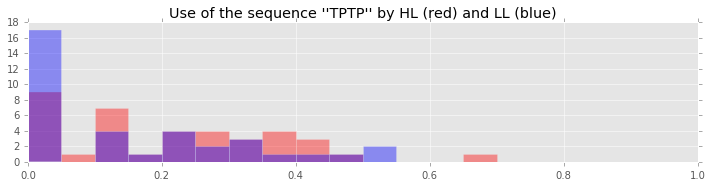

In [40]:
seq = 'TPTP'
run_chi2(seq,blocks_merged_HL,blocks_merged_LL)
run_chi2(seq,blocks_merged_HL,blocks_merged_LL,consider_if='TP')
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='TP')
perform_comparative_stats(seq,freq_HL,freq_LL)
plot = make_hist_continuous(seq,freq_HL,freq_LL)

-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        15        19       34
didn't use it  23        17       40
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=0.71216030271757835, pvalue=0.39872757529092895)
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        15        19       34
didn't use it  15        14       29
total          30        33       63
-------------  --------  -------  -----
Power_divergenceResult(statistic=0.16711229946524048, pvalue=0.68269105438143773)
TcCTcC :
	T-test:	-0.835 	 p=0.4065
	HL<LL:	620.5 	 p=0.2287
	HL>LL:	620.5 	 p=0.7749
	two-sided:	620.5 	 p=0.4574


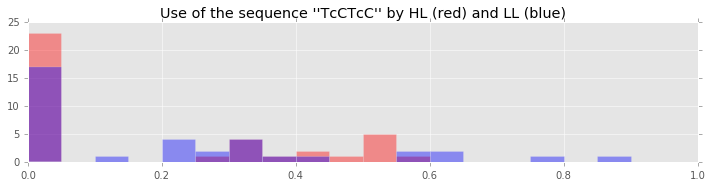

In [41]:
seq = 'TcCTcC'
run_chi2(seq,blocks_HL,blocks_LL)
run_chi2(seq,blocks_HL,blocks_LL,consider_if='TcC')
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='TcC')
perform_comparative_stats(seq,freq_HL,freq_LL)
plot = make_hist_continuous(seq,freq_HL,freq_LL)

-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        6         13       19
didn't use it  32        23       55
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=2.9733764235149267, pvalue=0.084645018044984713)
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        6         13       19
didn't use it  19        10       29
total          25        23       48
-------------  --------  -------  -----
Power_divergenceResult(statistic=3.2008237986270034, pvalue=0.073601187741718116)
TsCTsC :
	T-test:	-2.189 	 p=0.0323
	HL<LL:	536.0 	 p=0.0188
	HL>LL:	536.0 	 p=0.9818
	two-sided:	536.0 	 p=0.0376


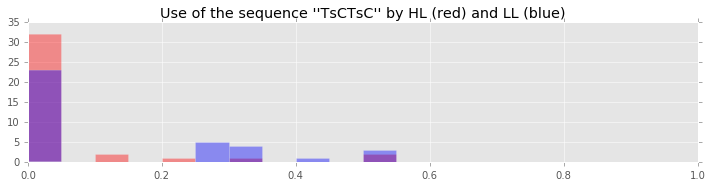

In [42]:
seq = 'TsCTsC'
run_chi2(seq,blocks_HL,blocks_LL)
run_chi2(seq,blocks_HL,blocks_LL,consider_if='TsC')
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='TsC')
perform_comparative_stats(seq,freq_HL,freq_LL)
plot = make_hist_continuous(seq,freq_HL,freq_LL)

-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        27        28       55
didn't use it  11        8        19
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=0.11249335459861755, pvalue=0.73732314915154507)
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        27        28       55
didn't use it  10        8        18
total          37        36       73
-------------  --------  -------  -----
Power_divergenceResult(statistic=0.055910455910455903, pvalue=0.81308046063372297)
TCTC :
	T-test:	-1.213 	 p=0.2293
	HL<LL:	572.0 	 p=0.1117
	HL>LL:	572.0 	 p=0.8904
	two-sided:	572.0 	 p=0.2234


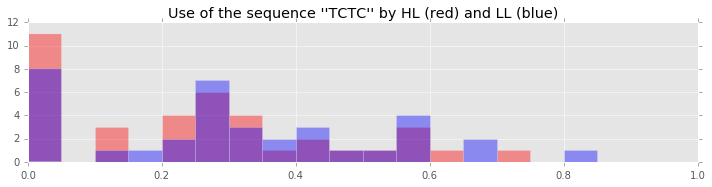

In [43]:
seq = 'TCTC'
run_chi2(seq,blocks_merged_HL,blocks_merged_LL)
run_chi2(seq,blocks_merged_HL,blocks_merged_LL,consider_if='TC')
freq_HL,freq_LL = get_frequencies(seq,blocks_merged_HL,blocks_merged_LL,normalize_by='TC')
perform_comparative_stats(seq,freq_HL,freq_LL)
plot = make_hist_continuous(seq,freq_HL,freq_LL)

-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        28        31       59
didn't use it  10        5        15
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=0.35806323718901806, pvalue=0.54958383637604102)
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        28        31       59
didn't use it  10        5        15
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=0.35806323718901806, pvalue=0.54958383637604102)
PCPC :
	T-test:	-1.531 	 p=0.1302
	HL<LL:	556.5 	 p=0.0837
	HL>LL:	556.5 	 p=0.9179
	two-sided:	556.5 	 p=0.1675


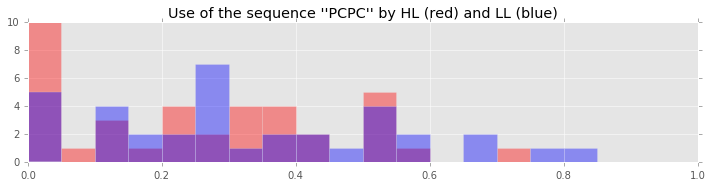

In [44]:
seq = 'PCPC'
run_chi2(seq,blocks_HL,blocks_LL)
run_chi2(seq,blocks_HL,blocks_LL,consider_if='PC')
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='PC')
perform_comparative_stats(seq,freq_HL,freq_LL)
plot = make_hist_continuous(seq,freq_HL,freq_LL)

-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        28        29       57
didn't use it  10        7        17
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=0.11331691802605928, pvalue=0.73639901715090883)
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        28        29       57
didn't use it  10        6        16
total          38        35       73
-------------  --------  -------  -----
Power_divergenceResult(statistic=0.19633293760717552, pvalue=0.65769721863490793)
CPCP :
	T-test:	-1.54 	 p=0.1281
	HL<LL:	556.5 	 p=0.0832
	HL>LL:	556.5 	 p=0.9185
	two-sided:	556.5 	 p=0.1664


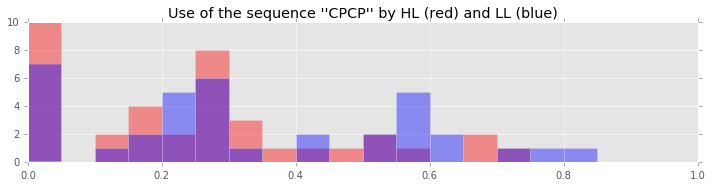

In [45]:
seq = 'CPCP'
run_chi2(seq,blocks_HL,blocks_LL)
run_chi2(seq,blocks_HL,blocks_LL,consider_if='CP')
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='CP')
perform_comparative_stats(seq,freq_HL,freq_LL)
plot = make_hist_continuous(seq,freq_HL,freq_LL)

TcCTcCTc 0.057
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        9         16       25
didn't use it  29        20       49
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=2.3583625730994164, pvalue=0.12461292712125759)
TcCTcCTc :
	T-test:	-1.224 	 p=0.2258
	HL<LL:	552.0 	 p=0.0457
	HL>LL:	552.0 	 p=0.9555
	two-sided:	552.0 	 p=0.0914


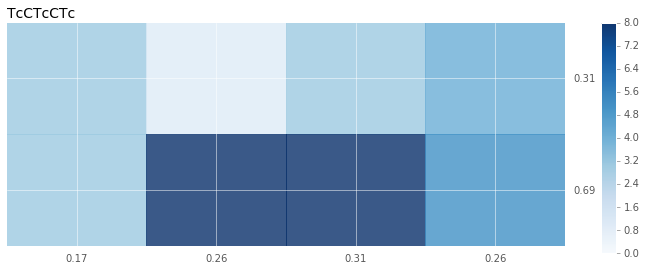

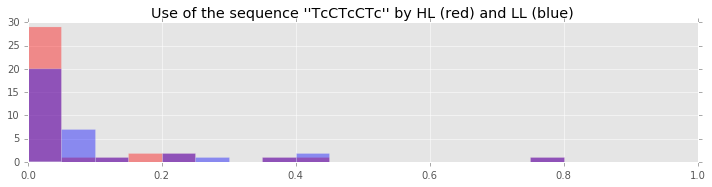



CPCPCP 0.071
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        10        19       29
didn't use it  28        17       45
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=3.303186126235127, pvalue=0.069145643965730863)
CPCPCP :
	T-test:	-1.733 	 p=0.0881
	HL<LL:	509.5 	 p=0.0163
	HL>LL:	509.5 	 p=0.9842
	two-sided:	509.5 	 p=0.0326


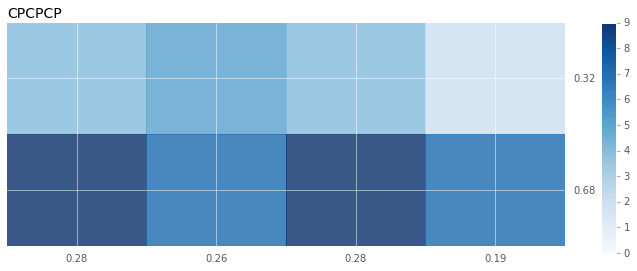

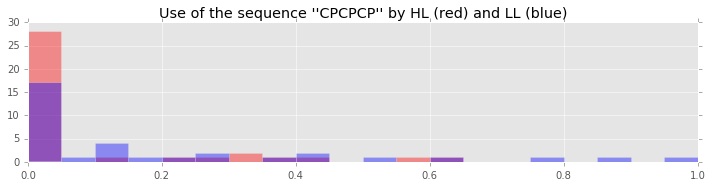



TsPTsP 0.082
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        14        7        21
didn't use it  24        29       53
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=1.971734892787524, pvalue=0.16026383324334748)
TsPTsP :
	T-test:	1.48 	 p=0.1433
	HL<LL:	808.0 	 p=0.9548
	HL>LL:	808.0 	 p=0.0465
	two-sided:	808.0 	 p=0.0931


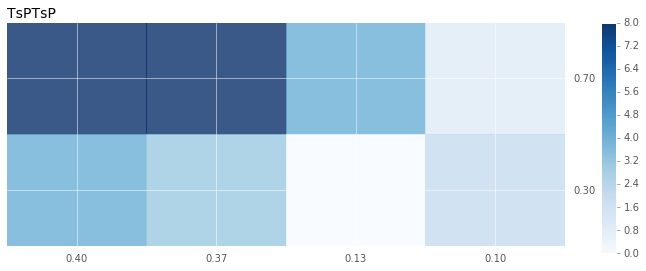

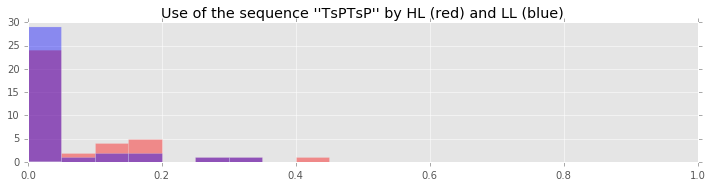



CPTsP 0.082
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        12        6        18
didn't use it  26        30       56
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=1.6900584795321629, pvalue=0.19359326046207714)
CPTsP :
	T-test:	1.9 	 p=0.0621
	HL<LL:	803.5 	 p=0.9577
	HL>LL:	803.5 	 p=0.0437
	two-sided:	803.5 	 p=0.0873


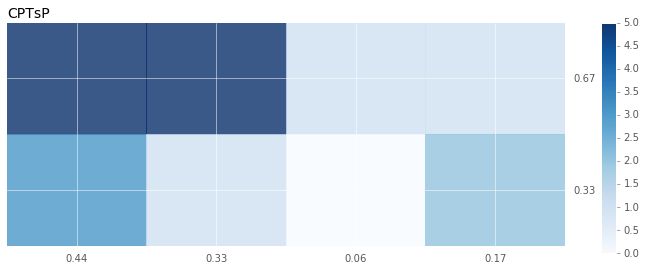

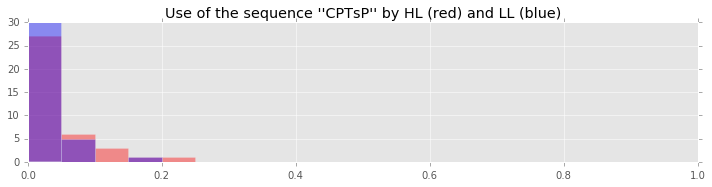



CPCPCPC 0.082
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        7         14       21
didn't use it  31        22       53
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=2.7290448343079929, pvalue=0.098538201423330057)
CPCPCPC :
	T-test:	-1.596 	 p=0.1154
	HL<LL:	535.5 	 p=0.0221
	HL>LL:	535.5 	 p=0.9786
	two-sided:	535.5 	 p=0.0442


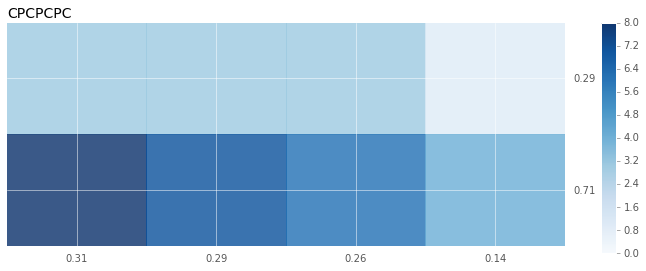

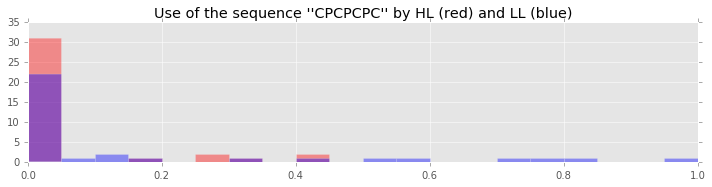



CPTs 0.098
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        15        7        22
didn't use it  23        29       52
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=2.4945507708665615, pvalue=0.1142409695046708)
CPTs :
	T-test:	1.772 	 p=0.0808
	HL<LL:	825.0 	 p=0.9709
	HL>LL:	825.0 	 p=0.03
	two-sided:	825.0 	 p=0.0601


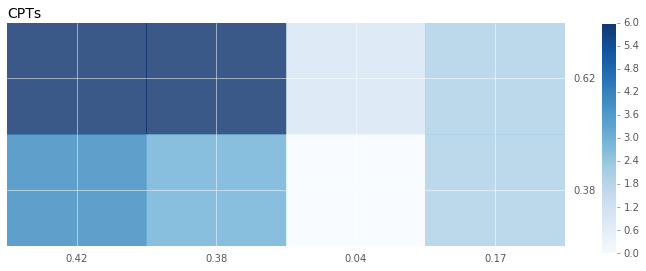

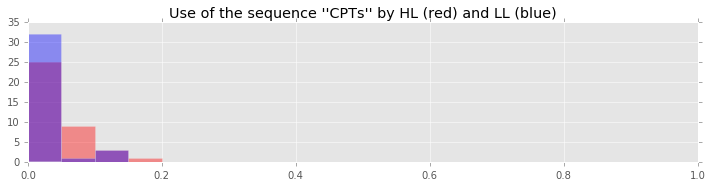



TsCTsC 0.1
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        6         13       19
didn't use it  32        23       55
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=2.9733764235149267, pvalue=0.084645018044984713)
TsCTsC :
	T-test:	-2.606 	 p=0.0122
	HL<LL:	524.5 	 p=0.0126
	HL>LL:	524.5 	 p=0.9879
	two-sided:	524.5 	 p=0.0251


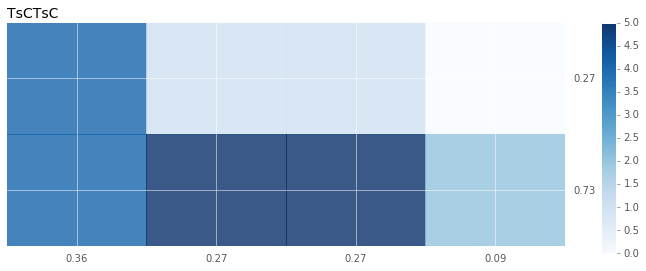

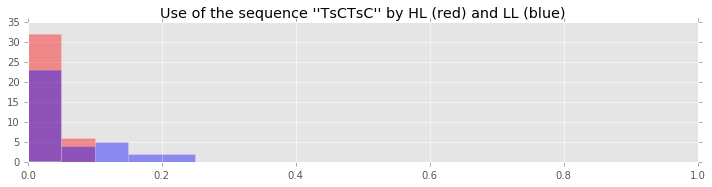



TcCPC 0.11
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        8         18       26
didn't use it  30        18       48
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=4.4089068825910918, pvalue=0.035751743676472783)
TcCPC :
	T-test:	-2.937 	 p=0.005
	HL<LL:	457.0 	 p=0.002
	HL>LL:	457.0 	 p=0.998
	two-sided:	457.0 	 p=0.0041


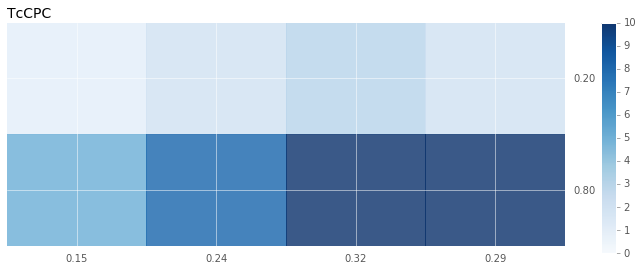

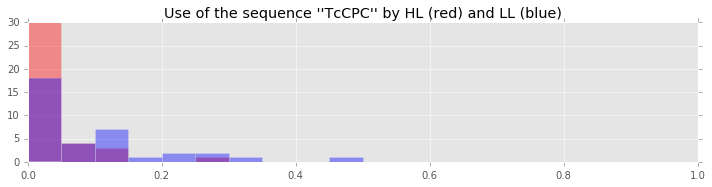



PCPCTcC 0.126
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        5         12       17
didn't use it  33        24       57
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=3.2755417956656352, pvalue=0.070319704224523077)
PCPCTcC :
	T-test:	-1.695 	 p=0.095
	HL<LL:	554.5 	 p=0.0291
	HL>LL:	554.5 	 p=0.9718
	two-sided:	554.5 	 p=0.0582


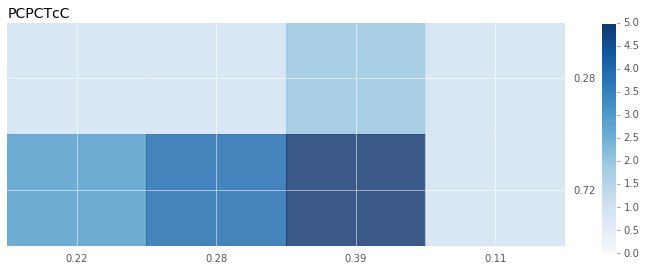

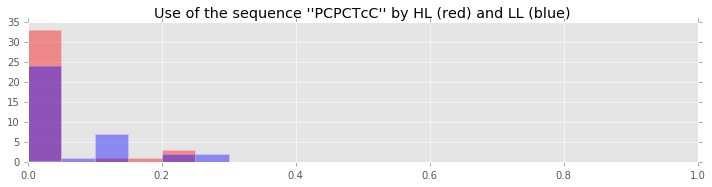



PTsP 0.143
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        23        9        32
didn't use it  15        27       42
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=5.3955592105263177, pvalue=0.020188055388821721)
PTsP :
	T-test:	2.006 	 p=0.0486
	HL<LL:	925.5 	 p=0.9981
	HL>LL:	925.5 	 p=0.002
	two-sided:	925.5 	 p=0.0039


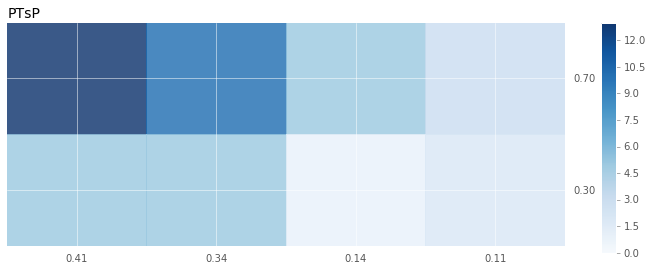

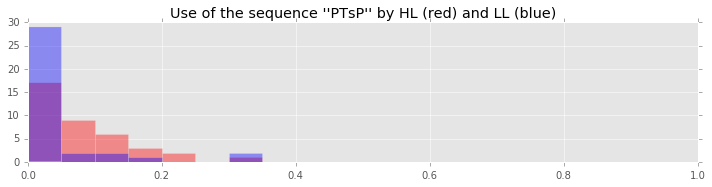



CTsPTsP 0.148
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        13        5        18
didn't use it  25        31       56
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=3.1385640025990895, pvalue=0.076461099604056407)
CTsPTsP :
	T-test:	2.418 	 p=0.0194
	HL<LL:	837.0 	 p=0.9863
	HL>LL:	837.0 	 p=0.0142
	two-sided:	837.0 	 p=0.0284


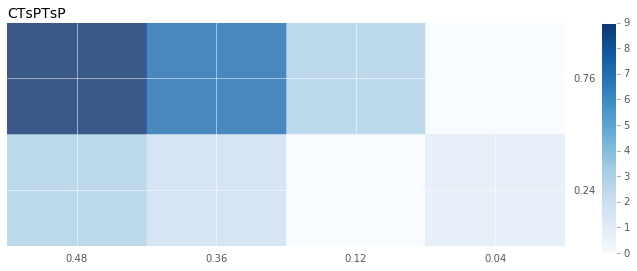

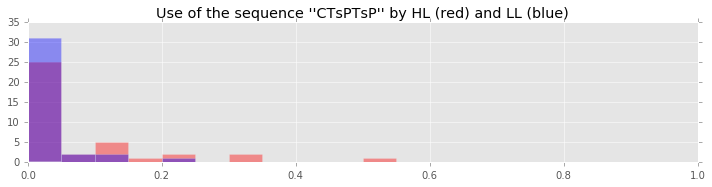



CPCTsC 0.148
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        5         13       18
didn't use it  33        23       56
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=4.0040610786224828, pvalue=0.045390772120374082)
CPCTsC :
	T-test:	-1.881 	 p=0.0645
	HL<LL:	537.5 	 p=0.0179
	HL>LL:	537.5 	 p=0.9827
	two-sided:	537.5 	 p=0.0359


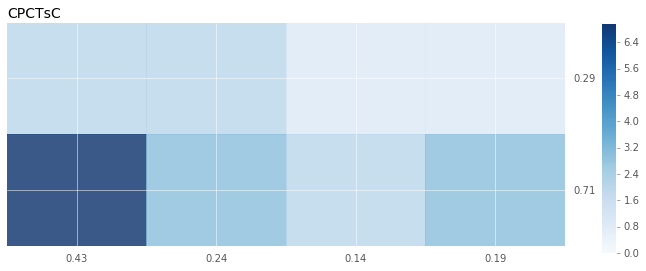

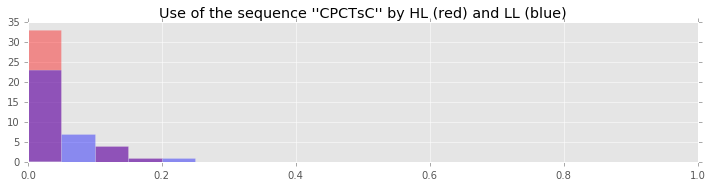



TsPTsPC 0.148
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        13        5        18
didn't use it  25        31       56
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=3.1385640025990895, pvalue=0.076461099604056407)
TsPTsPC :
	T-test:	2.247 	 p=0.0288
	HL<LL:	832.5 	 p=0.9839
	HL>LL:	832.5 	 p=0.0167
	two-sided:	832.5 	 p=0.0335


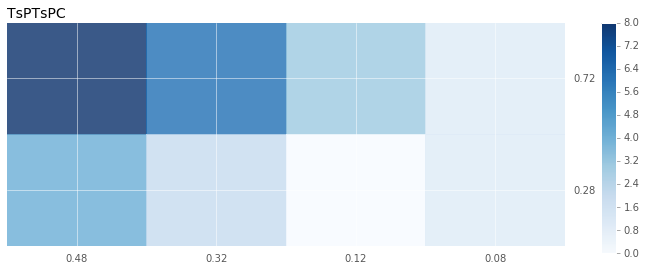

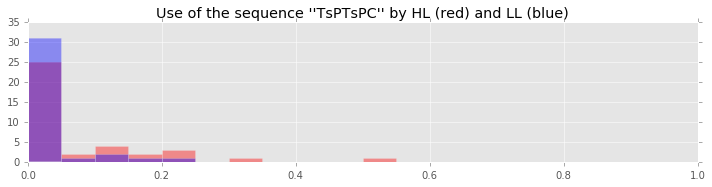



PCTcCTcC 0.148
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        5         13       18
didn't use it  33        23       56
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=4.0040610786224828, pvalue=0.045390772120374082)
PCTcCTcC :
	T-test:	-1.152 	 p=0.253
	HL<LL:	549.5 	 p=0.0271
	HL>LL:	549.5 	 p=0.9738
	two-sided:	549.5 	 p=0.0542


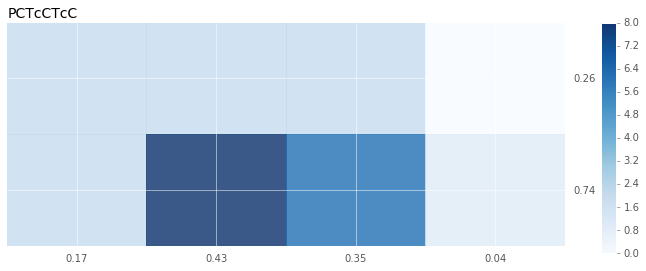

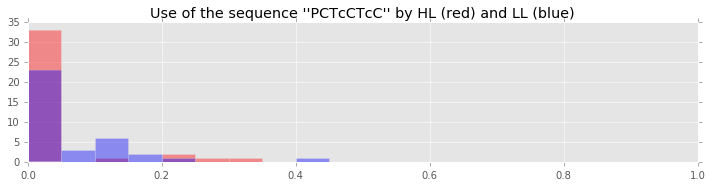



PTsPC 0.174
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        20        7        27
didn't use it  18        29       47
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=5.5803552090101789, pvalue=0.018163038403781327)
PTsPC :
	T-test:	2.628 	 p=0.0107
	HL<LL:	918.5 	 p=0.9984
	HL>LL:	918.5 	 p=0.0017
	two-sided:	918.5 	 p=0.0033


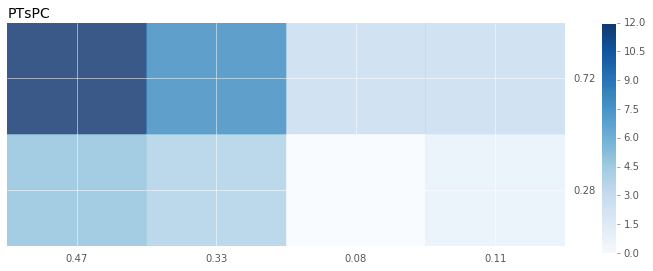

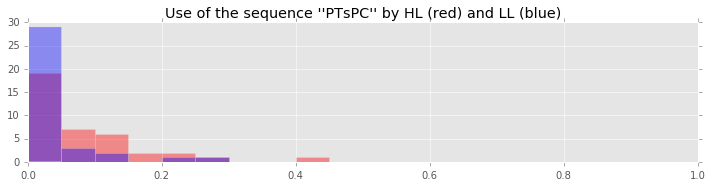

In [46]:
seqs = [("TcCTcCTc", 0.0573168107445),("CPCPCP", 0.0706363739863),("TsPTsP", 0.0817041659455),("CPTsP", 0.0817041659455),("CPCPCPC", 0.0817041659455),("CPTs", 0.097606717205),("TsCTsC", 0.100256241302),("TcCPC", 0.109508359781),("PCPCTcC", 0.126018951873),("PTsP", 0.142851562572),("CTsPTsP", 0.147594821351),("CPCTsC", 0.147594821351),("TsPTsPC", 0.147594821351),("PCTcCTcC", 0.147594821351),("PTsPC", 0.174373473842)]
for seq,infogain in seqs:
    print seq, round(infogain,3)
    run_chi2(seq,blocks_HL,blocks_LL)
    freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='length')
    perform_comparative_stats(seq,freq_HL,freq_LL)
    plot_heat_map(sequence_counts[seq],seq,'')
    make_hist_continuous(seq,freq_HL,freq_LL)
    plot.show()
    print '\n'

Clearly, repetition blocks are too comon to be significant.

However, our strategies recovered from information gain rank are used differentitally by high and low learners:

** <font color='blue'> PTsPC used more by high ($p < 0.05$) </font> **

** <font color='blue'> PCPCTcC used more by low ($p < 0.05$) </font> **

** <font color='blue'> PCTcCTcC used more by low ($p < 0.05$) </font> **

### Let's just check that most HL do at least 1 of the seqs and same for the LL

In [47]:
def coo(seq, seq_of_interest):
    if occurrences("".join(seq),seq_of_interest) >=1:
        return 1
    else:
        return 0
        
seqs_HL = [("TsPTsP", 0.0817041659455),("CPTsP", 0.0817041659455),
        ("CPTs", 0.097606717205),("PTsP", 0.142851562572),
        ("CTsPTsP", 0.147594821351),("TsPTsPC", 0.147594821351),
        ("PTsPC", 0.174373473842)]
seqs_LL = [("TsCTsC", 0.0817041659455),("PCTcCTcC", 0.147594821351),
           ("PCPCTcC", 0.147594821351)]
students_doit_HL = set()
students_doit_LL = set()
print 'for HL seqs'
for seq_of_interest,i in seqs_HL:
    students_HL_for_seq = set([s for s,seq in blocks_HL.iteritems() if coo(seq,seq_of_interest) >0])
    students_LL_for_seq = set([s for s,seq in blocks_LL.iteritems() if coo(seq,seq_of_interest) >0])
    print seq_of_interest,'\t',len(students_HL_for_seq),'\t',len(students_LL_for_seq)
    students_doit_HL.update(students_HL_for_seq)
    students_doit_LL.update(students_LL_for_seq)
print '\nTOTAL','\t',len(students_doit_HL),'\t',len(students_doit_LL),'\n\n'

students_doit_HL = set()
students_doit_LL = set()
print 'for LL seqs'
for seq_of_interest,i in seqs_LL:
    students_HL_for_seq = set([s for s,seq in blocks_HL.iteritems() if coo(seq,seq_of_interest) >0])
    students_LL_for_seq = set([s for s,seq in blocks_LL.iteritems() if coo(seq,seq_of_interest) >0])
    print seq_of_interest,'\t',len(students_HL_for_seq),'\t',len(students_LL_for_seq)
    students_doit_HL.update(students_HL_for_seq)
    students_doit_LL.update(students_LL_for_seq)
print '\nTOTAL','\t',len(students_doit_HL),'\t',len(students_doit_LL)

for HL seqs
TsPTsP 	14 	7
CPTsP 	12 	6
CPTs 	15 	7
PTsP 	23 	9
CTsPTsP 	13 	5
TsPTsPC 	13 	5
PTsPC 	20 	7

TOTAL 	25 	10 


for LL seqs
TsCTsC 	6 	13
PCTcCTcC 	5 	13
PCPCTcC 	5 	12

TOTAL 	12 	25


-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        31        23       54
didn't use it  7         13       20
total          38        36       74
-------------  --------  -------  -----
Power_divergenceResult(statistic=0.79277669482347846, pvalue=0.37326183241160493)
Tb :
	T-test:	0.925 	 p=0.3579
	HL<LL:	803.5 	 p=0.905
	HL>LL:	803.5 	 p=0.0968
	two-sided:	803.5 	 p=0.1936


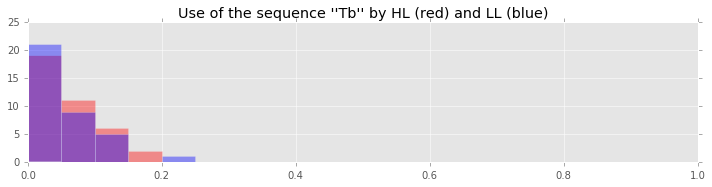

In [48]:
seq = 'Tb'
run_chi2(seq,blocks_HL,blocks_LL)
freq_HL,freq_LL = get_frequencies(seq,blocks_HL,blocks_LL,normalize_by='length')
perform_comparative_stats(seq,freq_HL,freq_LL)
plot = make_hist_continuous(seq,freq_HL,freq_LL)